# ロジスティック回帰

ベルヌーイ分布に従う変数の統計的回帰モデルの一種．主に二値分類で使われる．

---

## scikit-learnでの出力

In [13]:
import pandas as pd
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, Image, Video

線形分離可能なデータセットを作成する．\
線形非分離な問題についても後で突っ込んでみたいね．
- 線形非分離
- from sklearn.datasets import make_gaussian_quantiles

参考
- https://plantprogramer.com/data_generator/

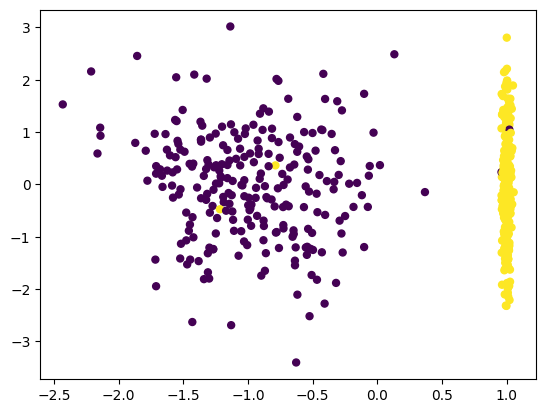

In [14]:
N = 500 #データの数
d = 2 # 次元数
K = 2 # クラス数

X, y = make_classification(
    n_samples=N,
    n_features=d,
    n_informative=1,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=K,
    random_state = 41
)

plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25) #c=yで色指定できる

本家skleanのLogisticRegressionではどのようなハイパーパラメータがあるかを確認

In [15]:
model = LogisticRegression(
    penalty=None,
    dual=False,
    tol=0.0001, #誤差の許容値，勾配降下のときに使うのかな？
    C = 1.0, # 正則化の強さ
    fit_intercept= False,# バイアス項を入れるかどうか，どのように影響するかはよくわからない
    intercept_scaling= 1.0, # solver='liblinear'でfit_intercept=Trueのときに発動
    class_weight=None, # クラスの数に応じて重みを受けることができる．
    random_state=None, # solver=['sag','saga','liblinear']のときにデータをシャッフルする．
    solver='newton-cg', # newton-cg を実装したい
    max_iter=100,
    multi_class='auto',
    verbose=0, # 冗長と訳せる，確かいらない
    warm_start=False, # 前のソリューションの値をそのまま持ってくる，でない場合はただ初期化するだけ
    n_jobs=None, # 使用するcpuのコア数
    l1_ratio=None # elasticnetのときの正則化割合，l1の割合を操作できる．
    )

In [16]:
model.fit(X,y)
print('クラス数',model.classes_)
print('特徴量の数',model.n_features_in_)
print('coef',model.coef_)
print('intercept',model.intercept_)
print('反復数',model.n_iter_)

クラス数 [0 1]
特徴量の数 2
coef [[ 5.35818166 -0.25678443]]
intercept [0.]
反復数 [6]


In [17]:
pred = model.predict(X)
print(accuracy_score(y, pred))

0.986


- バイアス項の有無
- solverの違い

で出力が変わる．どう違うのかはよくわからぬ．

---
## 理論
ロジスティック回帰の気持ち，流れを先に整理する

### イメージで理解する

ベースは線形回帰なのでイメージをつかもう．\
線形回帰はざっくり以下のイメージ．

[]

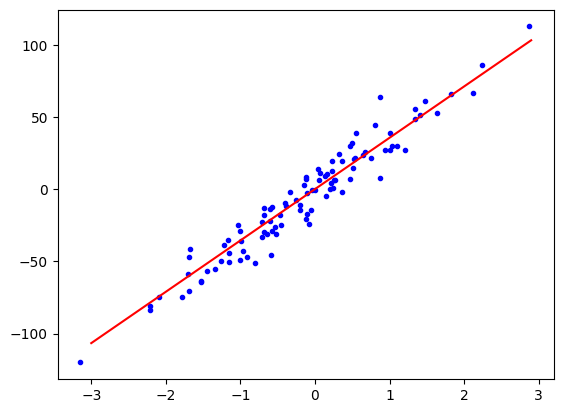

In [87]:
from sklearn.datasets import make_regression

x_reg, y_reg, coef_reg = make_regression(random_state=12,
                       n_samples=100,
                       n_features=1,
                       n_informative=1,
                       noise=10.0,
                       bias=-0.0,
                       coef=True)

x0 = np.arange(-3,3,0.1)

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg, marker='.',color='blue') #なぜかmarkerだけだと点が繋がる
plt.plot(x0,x0*coef_reg, color='red')
plt.plot()

これをうまく二値分類に適用することを考える．\
しかし，問題がある．**目的変数が二値であること**だ．\
って言われてもイメージがつきにくい．図で見るとこんな状況が発生している．

[]

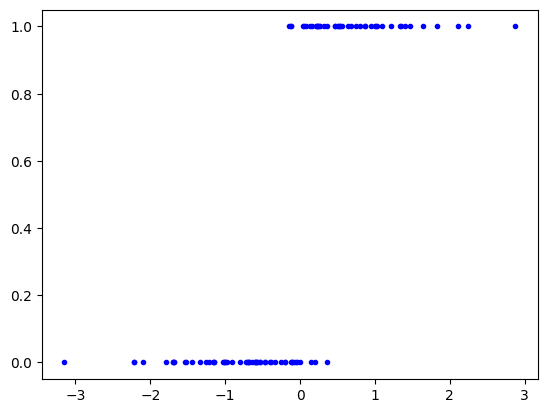

In [146]:
y_reg_0or1 = y_reg[:]

for i in range(len(y_reg_0or1)):
    if y_reg_0or1[i] > 0:
        y_reg_0or1[i] = 1
    else:
        y_reg_0or1[i] = 0

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg_0or1, marker='.',color='blue') #なぜかmarkerだけだと点が繋がる
plt.plot()

これは一個前の図で$y$<0なら0，$y$>0なら1とした図である．(0,1には数値的な意味はない．ブール値のように捉えてほしい．)\
ここに線形回帰のように直線を引いて適切な予測ができるだろうか？\
どう考えても無理だろう．ということで何か良い方法を考える．\
そこで，線形回帰の直線を曲げることを考える．(ロジスティック変換)

[]

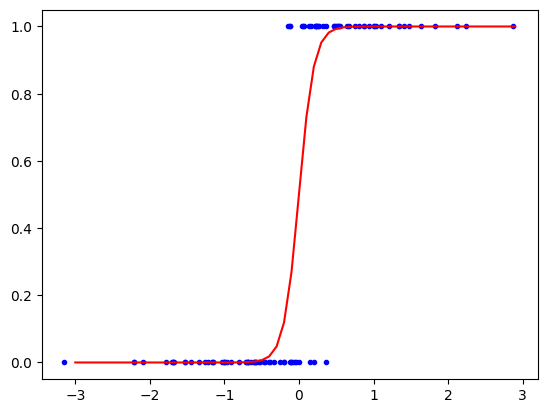

In [155]:
def sigmoid_method(x, gain):
    return 1 / (1 + np.exp(-x * gain))

sigmoid_x = np.arange(-3, 3, 0.1)

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg_0or1, marker='.',color='blue') #なぜかmarkerだけだと点が繋がる
plt.plot(sigmoid_x,sigmoid_method(sigmoid_x, gain=10), color='red')
plt.plot()

こんな感じ．\
実はこれはsigmoid関数を使っている．このようにして二値分類を実現する．\
ステップ関数でもいいじゃんとか思うかもしれないが，実装のときにステップ関数だとダメな理由がわかると思う．\
それに結局微分するのでステップ関数は使わない．

ひとまずイメージは掴めた．あとはどうやるのかを数学的に追うだけ．

### 数学で理解する

$N$:データ数\
$d$:次元数\
$X\in \mathbb{R}^{N\times d}$:説明変数\
$\boldsymbol{y}\in \mathbb{R}^{N\times 1}$:目的変数\
$\boldsymbol{w}\in \mathbb{R}^{d\times 1}$:パラメータ

今やったことを数式で説明しよう．\
まず線形回帰の式を用意する．
$$
X\boldsymbol{w}
$$
これだね．\
次にsigmoid関数を用意する．
$$
\sigma(x) = \frac{1}{1-e^{-x}}
$$
そしてsigmoid関数に線形回帰の式を代入する．
$$
\boldsymbol{\hat{y}} = \frac{1}{1-e^{-X\boldsymbol{w}}} \\
$$
はい，これで出力値が**ほぼ二値**(0,1)のモデルができた．\
ほぼ二値なのはsigmoid関数の形を見れば明らか．\
そこで最終的にはsigmoid関数の出力を0.5を基準に二値に分ける操作が必要である．別に大したことではないね．

ではでは，適切なパラメータ$\boldsymbol{w}$を求めていこう．\
ここで残念なお知らせ．最小二乗法は使えない．\
その理由を整理しよう．

もう一度言おう，目的変数は二値だ．\
ということは予測値も二値で出力することになる．以下の損失関数は適切か？\
残差を$\boldsymbol{J}\in N$とする．
$$
\begin{align}
\boldsymbol{J} &= \|\boldsymbol{y}-\boldsymbol{\hat{y}}\|_2^2 \\
&= \|\boldsymbol{y}-\frac{1}{1-e^{-X\boldsymbol{w}}} \|_2^2

\end{align}
$$
正直自分が数学ができないのでこれがダメな理由をはっきりということができない．\
少なくともこれよりも適切な損失関数は存在する．

※一応最小二乗法を使えない理由を一つ述べる．\
　最小二乗法は正規分ぴのパラメータに対して使用する手法である．\
　今回の目的変数は二値なので試行回数1回の二項分布，したがってベルヌーイ分布と捉えられる．\
　正規分布以外のパラメータの点推定で登場するのが**最尤法**である．

細かいことは置いておいて，尤度を$L$としたとき，以下のようになる．\
二値データ$Y$が$Y=1$となる確率を$P=p(Y=1)$，$Y=0$となる確率を$1-P=p(Y=0)$とする．\
$Y(Y_1,Y_2,...,Y_N)$が独立であり，$p(Y_i=1)=P_i$であるとき尤度$L$は以下になる．
$$
L = \prod_{i=1}^N P_i^{Y_i}(1-P_i)^{1-Y_i}
$$
$Y_i=1$のとき，$P_i^{Y_i}$が残って，$Y_i=0$のとき$(1-P_i)^{1-Y_i}$が残る．ただそれを表しているだけ．

お決まりのとおり対数尤度をとる．計算しやすいから．
$$
\begin{align}
log(L) &= log(\prod_{i=1}^N P_i^{Y_i}(1-P_i)^{1-Y_i}) \\
&= \sum_{i=1}^{N}(Y_i logP_i+(1-Y_i)log(1-P_i))\\
\end{align}
$$
この対数尤度を最大化(もしくは負の対数尤度を最小化する)\
言い忘れてたけど
$$
P_i = \frac{1}{1+e^{-X_i\boldsymbol{w}}}
$$

整理する．\
対数尤度関数はもうあるよね．対数尤度関数のパラメータ$P_i$もあるよね．\
しかしパラメータ$\boldsymbol{w}$がわかっていないよね．ここをニュートン法で求めていく．

今回の実装はバイアス項なし，かつnewton,newton-cg,lbfgsを実装したい．要はパラメータの求め方だけ違うってこと．

### ニュートン法とは

$$
\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})
$$
これがパラメータ$\boldsymbol{w}$の更新式．これを繰り返すことで自ずと適切なパラメータが求められる．\
これを解いていくためには$H$，ヘッセ行列が必要である．\
ちなみに$\nabla E(\boldsymbol{w}^{old})$はただの一階微分

一旦，イメージが掴みやすいようにニュートン法によって$(x - 1)^2$の解を近似的に求めてみる．\
このときのニュートン法の式は以下
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}
$$

In [18]:
x = 3.0
for i in range(1000):
    x_new = x - (x**2 -2*x + 1) / (x * 2)
    if abs(x_new - x) < 0.000001:
        break
    x = x_new
print(x)

1.0020126004553584


In [57]:
def here_function(x):
    y = (x - 1) ** 2
    return y

def zero_function(x):
    return 0

def diff(diff_x,x, intercept):
    return x * (diff_x-x) * 2 + intercept

start = 0 #定義域の左端
last = 6 # 定義域の右端

x0 = np.arange(start,last, 0.01)
y0 = here_function(x0)
diff_x = np.arange(0,8, 0.01)

fig = plt.figure() # Figureオブジェクトを作成
ax = fig.add_subplot(1,1,1) # figに属するAxesオブジェクトを作成
#ax.set_aspect('equal')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlim(-1,7)
ax.set_ylim(-1,26)

ax.grid() # グラフにグリッドを追加

dx = 0.1
ax.plot(x0, y0)

artist_list = []
point_list_x = []
point_list_y = []
point__list_0 = []

x = 6.0
for i in range(150):
    y = here_function(x)
    zero = zero_function(x)

    x_new = x - y / (x * 2)
    if abs(x_new - x) < 0.001:
        break
    point_list_x.append(x)
    point_list_y.append(y)
    point__list_0.append(zero)

    art = plt.plot(point_list_x, point_list_y, marker='.', markersize=10, color='red', linestyle='None')
    art += plt.plot(point_list_x, point__list_0, marker='.', markersize=10, color='red',linestyle='None')
    art += plt.plot(diff_x, diff(diff_x,x,y), marker='.',markersize=1 ,color='pink',linestyle='None')

    artist_list.append(art)
    x = x_new

ani = ArtistAnimation(fig, artist_list, interval = 200)

plt.close()
HTML(ani.to_jshtml())

んーなんか違う...気になるけど後で修正することにする．\
解自体は求まっているのでね．

ニュートン法のイメージが掴めた．ということで$\boldsymbol{w}^{new}$についても同様に理解したい．\
ニュートン法の式と今回使う式の対応を考えよう．\
今回の式は以下
$$
\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})
$$
ニュートン法の式は以下
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}
$$
一見何が対応しているのかわからないが，整理していく．\
$H^{-1}$はヘッセ行列(二階微分)の逆行列であり．$\frac{1}{f'(x_1)}$に対応する．$f'(x)^{-1}$と書くとわかりやすい．\
$\nabla E(\boldsymbol{w}^{old})$はただの一階微分であり，$f(x_1)$に対応する．

今回は最終的に$\nabla E(\boldsymbol{w})\simeq 0$をニュートン法で目指す．

更新式は以下
$$
\boldsymbol{w}^{new} = \boldsymbol{w}^{old}-H^{-1}\Delta E (\boldsymbol{w}^{old})
$$
$$
\boldsymbol{w}^{new} = (X^TRX)^{-1}(X^TR)[X\boldsymbol{w}^{old}-R^{-1}(\hat{y}-y)]
$$

更新式(パラメータについての式)が求められたということは，実装できるということ．\
やってみよう．

---
# 実装
ポイントを以下に書く．
- パラメータ:$\boldsymbol{w}^{new} = (X^TRX)^{-1}(X^TR)[X\boldsymbol{w}^{old}-R^{-1}(\hat{y}-y)]$
- モデル:$\boldsymbol{\hat{y}} = \frac{1}{1-e^{-X\boldsymbol{w}}}$\
最終的な出力は二値なのでモデルの出力を0.5を基準に0と1に分けてあげて出力するといいかも．

tolでbreakしないパターン

In [ ]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100): # ハイパラは最初にここで初期化
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def _predict(self, x):
        return self._sigmoid(np.dot(x, self.w)) # 線形回帰を行い，シグモイド関数に通す

    def _get_w(self, x, y, y_hat):
        for _ in range(X.shape[0]): # データ数だけ繰り返す
            self.R[_,_] = y_hat[_] * (1 - y_hat[_]) # 予測値_n(1-予測値_n)を対角行列に入れる
        w_new = (np.linalg.pinv((x.T @ self.R) @ x) @ (x.T @ self.R)) @ (x @ self.w - np.linalg.pinv(self.R) @ (y_hat - y)) # 更新式
        return w_new

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1]) # d次元ベクトルのwを作成
        self.R = np.identity(x.shape[0]) # n×nの対角行列を用意
        for i in range(self.max_iter):
            y_hat = self._predict(x) # 一旦ここで予測する．
            self.w = self._get_w(x, y, y_hat) # 重みの更新

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

tolでちゃんとbreakするパターン

In [ ]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def _predict(self, x):
        return self._sigmoid(x @ self.w)

    def _get_w(self, x, y, y_hat):
        for _ in range(X.shape[0]):
            self.R[_,_] = y_hat[_] * (1 - y_hat[_])
        xr = x.T @ self.R
        w_new = (np.linalg.pinv(xr @ x) @ xr) @ (x @ self.w - np.linalg.pinv(self.R) @ (y_hat - y))
        diff = w_new - self.w
        return w_new, diff

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        for i in range(self.max_iter):
            y_hat = self._predict(x)
            w_new, diff = self._get_w(x, y, y_hat)
            if np.all(diff < tol_vec):
                break
            elif np.any(diff > tol_vec):
                self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [ ]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)
Smodel.fit(X, y)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

coef_ [ 5.36677718 -0.25818371]
accuracy 0.986


大体一致してる．(なぜかたまに失敗するけど...)\
interceptないバージョンだからこれでよし

今気づいたけど，ニュートン法では$\nabla E(\boldsymbol{w}^{old})\simeq 0$を目指すって言ってるのに$\boldsymbol{w}^{new}-\boldsymbol{w}^{old}\simeq 0$でbreakしちゃってるね．\
言ってることとやってることあってないわ．

### Newton-CG法を考える．